# Let's guess the mood of a music

The goal of this project is to be able to automatically determine if a music is sad or happy. We will use the library [librosa](https://librosa.org/doc/latest/index.html). This will allow us to visualize and get information about the music.
We have downloaded 10 "sad" musics and 10 "happy" musics. They are placed in the folder ./data/musics/ and begin with a for the happy musics and b for the sad musics.

In [1]:
%load_ext autoreload
%autoreload 2
data_dir = "./data/"
from utilities import *

In [2]:
import librosa # for working with audio in python
import librosa.display # for waveplots, spectograms, etc
import soundfile as sf # for accessing file information
import IPython.display as ipd # for playing files within python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline

## 1) Loading data and getting started with librosa
Our first step will be to load the data and extract information with the librosa audio library.

In [3]:
musics = ls("./data/musics")

In [4]:
musics = ls("./data/musics")
y,sr = librosa.load("./data/musics/" + musics[10], offset=15, duration=3)
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
#df = pd.DataFrame(y, columns=['Amplitude'])
#df.index = [(1/sr)*i for i in range(len(df.index))]
tempo # regardons à quoi ça ressemble

112.34714673913044

In [5]:
# nous donne une série de tuples contenant : la musique en position 0 et son nom en position 1
# Pour que le chargement soit plus rapide et plus pertinent, seules 15 secondes sont chargées et cela après 15 premières secondes
musics = load_musics(data_dir + "musics/")
print("done")

done


# 2) Let's display our data
We are now going to visualize our data. Maybe it will give us some ideas for features.

## Let's start by displaying the spectrum of our music samples

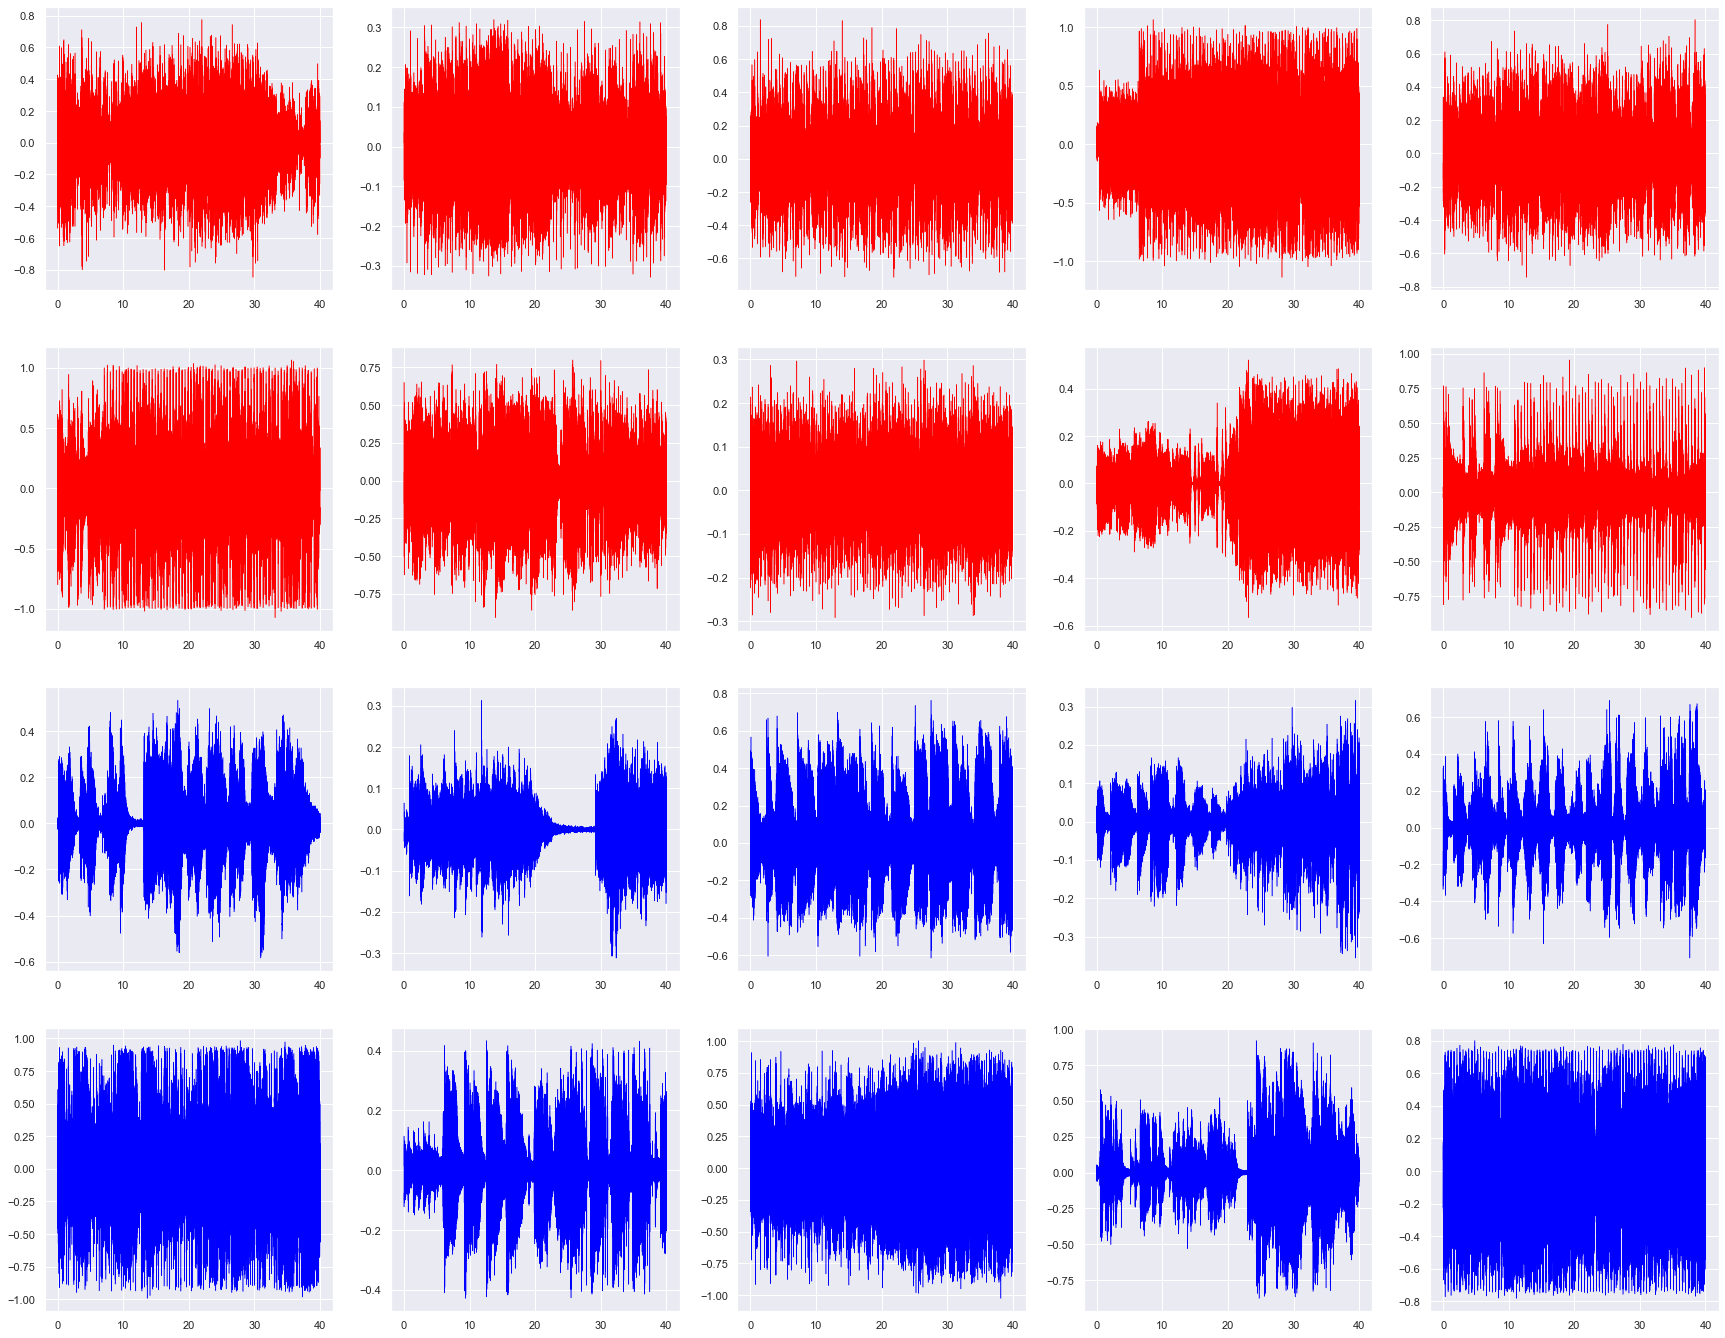

In [6]:
plt_compare2(musics, lambda music : music[0])

## 3) We will now display the results of spectral_centroid, a feature that seems promising
According to wikipedia.org:
> The spectral centroid is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located. Perceptually, it has a robust connection with the impression of brightness of a sound.

And according librosa:
> Each frame of a magnitude spectrogram is normalized and treated as a distribution over frequency bins, from which the mean (centroid) is extracted per frame.

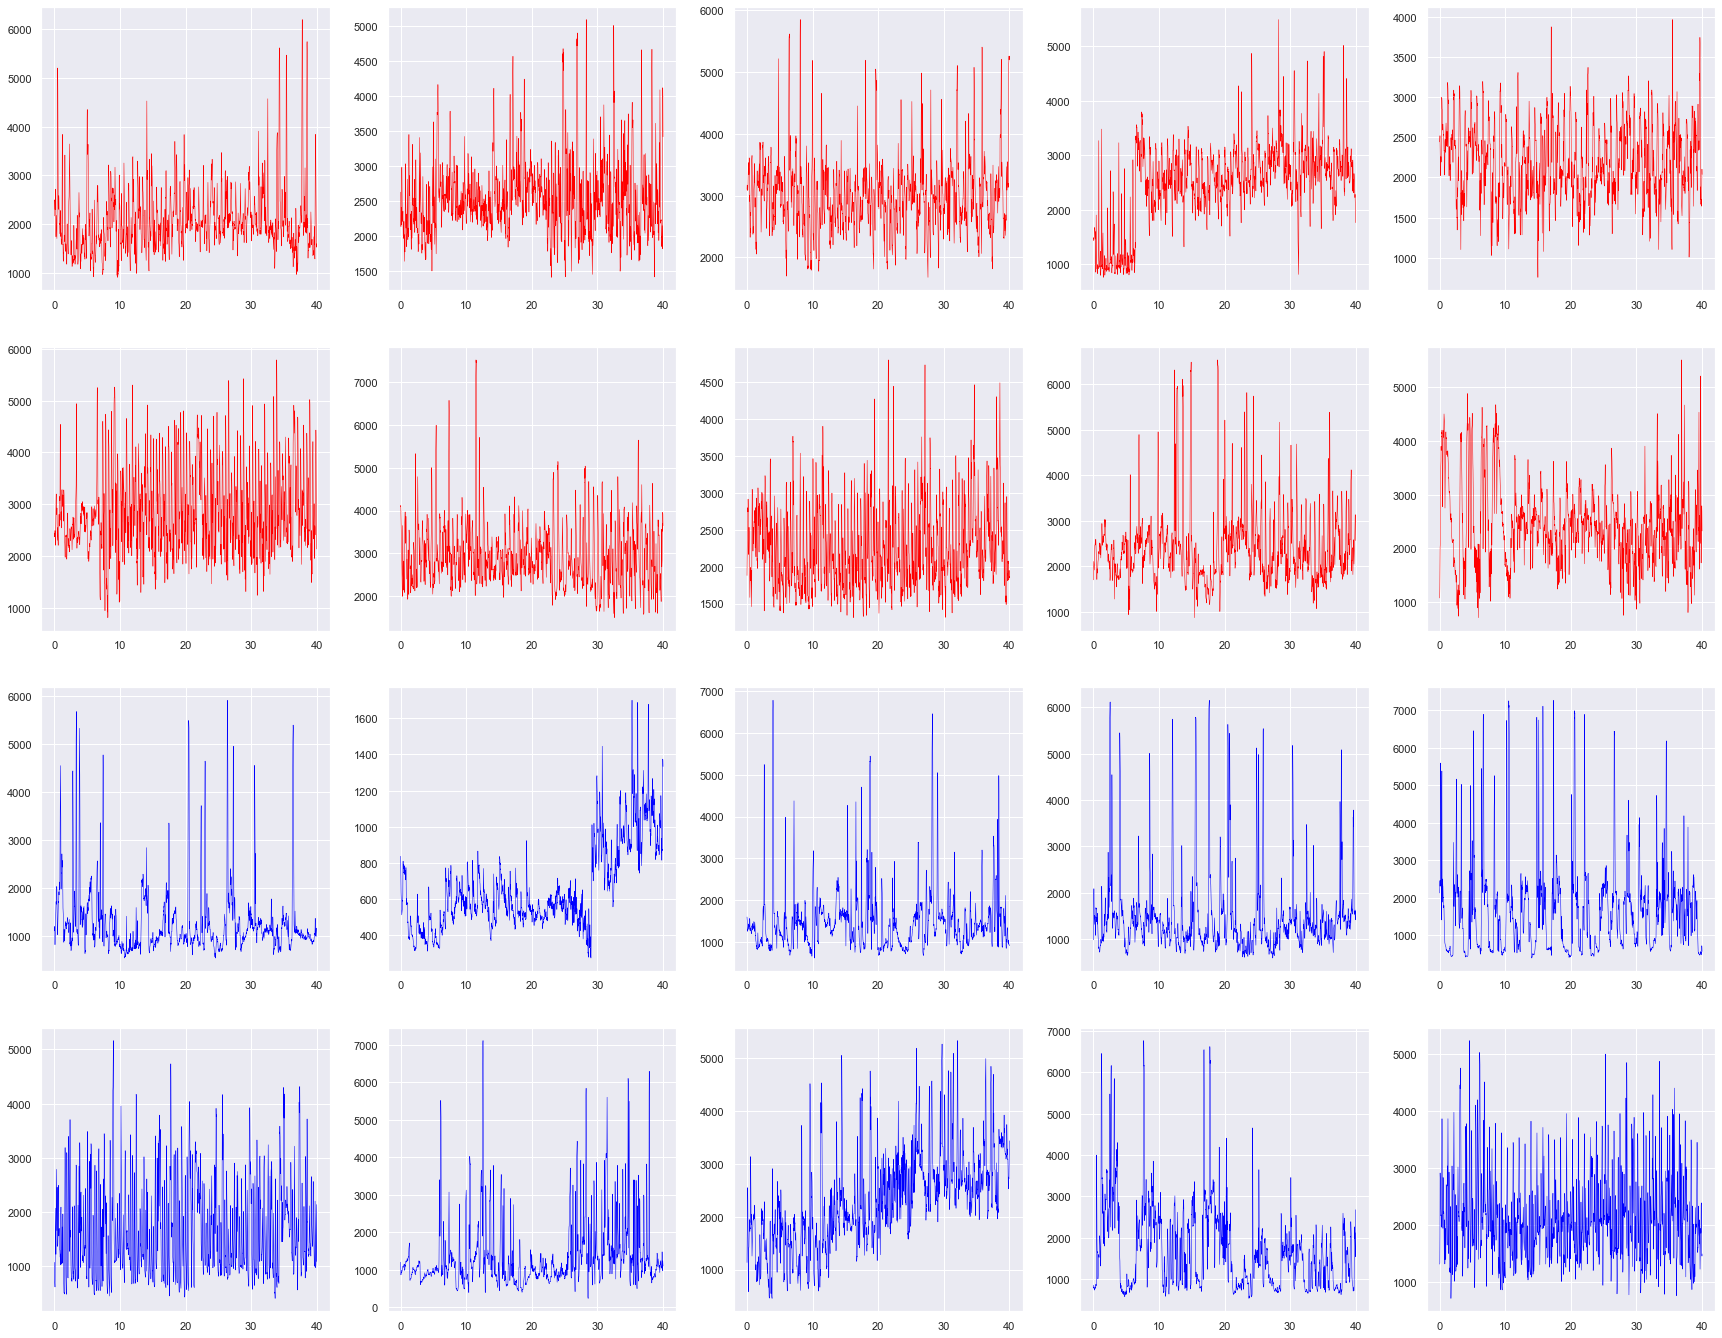

In [7]:
plt_compare2(musics, spect_cent)

# 4) Let's test our features
After looking at the different possibilities of librosa we have selected some features that might be interesting to implement. We will now test them and see if they give us consistent results.

In [8]:
df = pd.DataFrame({
	'amplitude' : musics.apply(mean_amplitude),
    'spectral_centroid' : musics.apply(spectral_centroid_mean),
	'tempo' : musics.apply(get_tempo),
	'classe': musics.index.map(lambda name: 1 if name[0] == 'a' else -1),
})

In [9]:
dfstd = df
dfstd = (df - df.mean()) / df.std()
dfstd["classe"] = df["classe"]
dfstd.style.background_gradient(cmap='RdYlBu_r')

# 5) Let's try another display

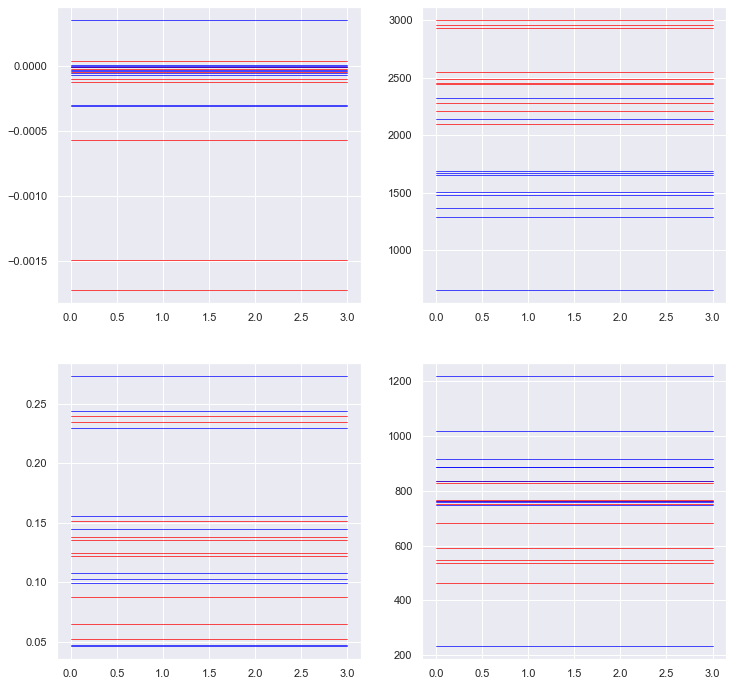

In [10]:
fig = plt.figure(figsize=(12, 12))
ax_P = fig.add_subplot(2, 2, 1)
plt_compare(musics, mean_amplitude, ax_P)
ax_Q = fig.add_subplot(2, 2, 2)
plt_compare(musics, spectral_centroid_mean, ax_Q)
ax_R = fig.add_subplot(2, 2, 3)
plt_compare(musics, amplitude_std, ax_R)
ax_S = fig.add_subplot(2, 2, 4)
plt_compare(musics, spectral_centroid_std, ax_S)

# 6) Let's check the correlation matrix

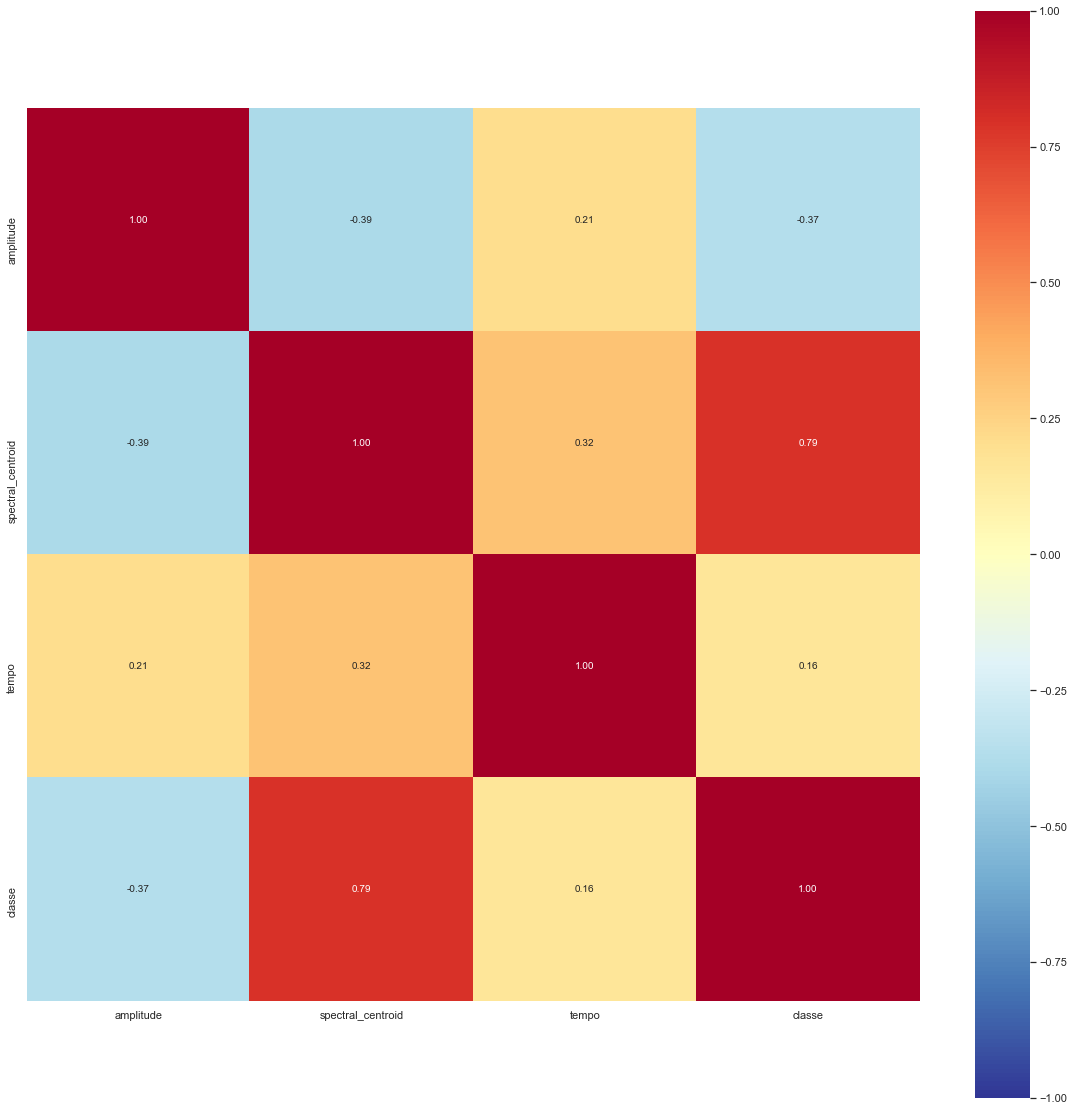

In [11]:
fig = Figure(figsize=(20,20))
sns.heatmap(dfstd.corr(), fmt='0.2f', annot=True, square=True, cmap='RdYlBu_r', vmin=-1, vmax=1, ax=fig.add_subplot())
fig

# 7) To avoid choosing features that are well correlated to the class but give the same result between them, let's display the different scatter plots:

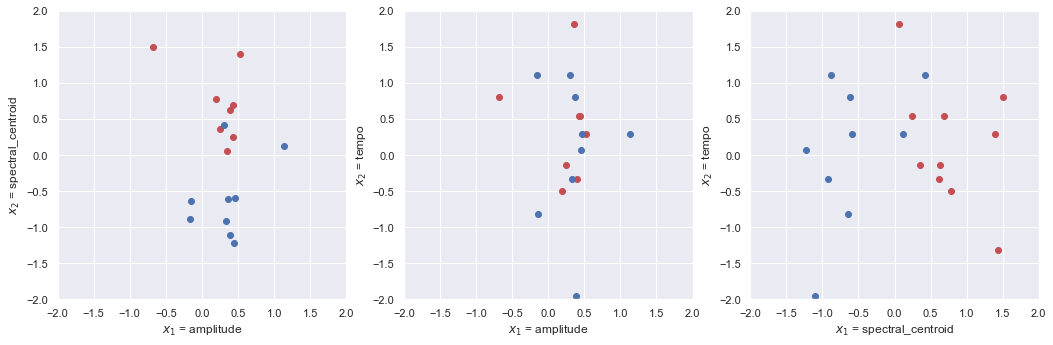

In [12]:
make_scatter_plot3(dfstd)

# Sandbox

In [13]:
#m = load_music_from_ytb("https://www.youtube.com/watch?v=EGOBLZNBiVM")
#y, sr = m

In [14]:
X = dfstd[['spectral_centroid', 'tempo']]
Y = dfstd['classe']

In [15]:
train_index, test_index = split_data(X, Y, verbose = True, seed=0)
Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]

TRAIN: [14 19  2 11  3 18 12  5  9  1] TEST: [ 0 17  4 13  6  8  7 16 10 15]


In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
neigh = KNeighborsClassifier(n_neighbors=3, algorithm="kd_tree")
neigh.fit(Xtrain, Ytrain)
Ytrain_predicted = neigh.predict(Xtrain)
Ytest_predicted = neigh.predict(Xtest)

print(Ytrain_predicted)

e_tr = error_rate(Ytrain_predicted, Ytrain)
e_te = error_rate(Ytest_predicted, Ytest)

print("Training error:", e_tr)
print("Test error:", e_te)

[-1  1  1 -1  1 -1 -1  1  1  1]
Training error: 0.1
Test error: 0.1


In [18]:
classifier = FNNClassifier()
classifier.fit(Xtrain, Ytrain)
Ytrain_predicted = classifier.predict(Xtrain)
Ytest_predicted = classifier.predict(Xtest)
e_tr = error_rate(Ytrain, Ytrain_predicted)
e_te = error_rate(Ytest, Ytest_predicted)

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(Xtrain, Ytrain)
neigh_Ytrain_predicted = neigh.predict(Xtrain)
neigh_Ytest_predicted = neigh.predict(Xtest)
neigh_e_tr = error_rate(Ytrain_predicted, Ytrain)
neigh_e_te = error_rate(Ytest_predicted, Ytest)

assert(neigh_e_tr == e_tr)
assert(neigh_e_te == e_te)

print("MY FNN CLASSIFIER")
print("Training error:", e_tr)
print("Test error:", e_te)

MY FNN CLASSIFIER
Training error: 0.0
Test error: 0.3


In [19]:
classifier = oneR()
classifier.fit(Xtrain, Ytrain) 
Ytrain_predicted = classifier.predict(Xtrain)
Ytest_predicted = classifier.predict(Xtest)
e_tr = error_rate(Ytrain, Ytrain_predicted)
e_te = error_rate(Ytest, Ytest_predicted)
print("MY ONER CLASSIFIER")
print("Training error:", e_tr)
print("Test error:", e_te)

MY ONER CLASSIFIER
Training error: 0.0
Test error: 0.4


In [20]:
classifier = KNNClassifier(k=3)
classifier.fit(Xtrain, Ytrain)
Ytrain_predicted = classifier.predict(Xtrain)
Ytest_predicted = classifier.predict(Xtest)

e_tr = error_rate(Ytrain, Ytrain_predicted)
e_te = error_rate(Ytest, Ytest_predicted)
print("MY (REALLY COOL <3) KNN CLASSIFIER")
print(e_tr)
print(e_te)

MY (REALLY COOL <3) KNN CLASSIFIER
0.1
0.1


In [21]:
classifier_test = RadiusNNClassifier()
classifier_test.fit(Xtrain, Ytrain)
Ytrain_predicted_test = classifier_test.predict(Xtrain)
Ytest_predicted_test = classifier_test.predict(Xtest)

e_tr_test = error_rate(Ytrain, Ytrain_predicted_test)
e_te_test = error_rate(Ytest, Ytest_predicted_test)
print("MY CUSTOM RADIUS CLASSIFIER")
print(e_tr_test)
print(e_te_test)

MY CUSTOM RADIUS CLASSIFIER
0.0
0.2


In [22]:
# YOUR CODE HERE
sigma = np.sqrt((e_te * (1-e_te))/10)

print("TEST SET ERROR RATE: {0:.2f}".format(e_te))
print("TEST SET STANDARD ERROR: {0:.2f}".format(sigma))

TEST SET ERROR RATE: 0.10
TEST SET STANDARD ERROR: 0.09


In [23]:
n_te = 10
SSS = StratifiedShuffleSplit(n_splits=n_te, test_size=0.5, random_state=5)
E = np.zeros([n_te, 1])
k = 0
for train_index, test_index in SSS.split(X, Y):
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]
    classifier.fit(Xtrain, Ytrain.ravel()) 
    Ytrain_predicted = classifier.predict(Xtrain)
    Ytest_predicted = classifier.predict(Xtest)
    e_te = error_rate(Ytest, Ytest_predicted)
    E[k] = e_te
    k = k+1
e_te_ave = np.mean(E)
# It is bad practice to show too many decimal digits:
print("CV ERROR RATE: {0:.2f}".format(e_te_ave))
print("CV STANDARD DEVIATION: {0:.2f}".format(np.std(E)))

sigma = np.sqrt(e_te_ave * (1-e_te_ave) / n_te)
print("TEST SET STANDARD ERROR (for comparison): {0:.2f}".format(sigma))

CV ERROR RATE: 0.18
CV STANDARD DEVIATION: 0.07
TEST SET STANDARD ERROR (for comparison): 0.12


In [24]:
m = load_music_from_ytb("https://www.youtube.com/watch?v=EGOBLZNBiVM")
guessHappiness(m, df, classifier)

La musique Glitter and Gold [ AMV - Mix ] Anime Mix est: Heureuse


In [25]:
m = load_music_from_ytb("https://www.youtube.com/watch?v=OcnuAHbI2WI")
guessHappiness(m, df, classifier)

La musique Kuzu Mellow - sunflower feelings (prod. by korou) est: Triste


In [26]:
m = load_music_from_ytb("https://www.youtube.com/watch?v=wRQEfN8PGYI")
guessHappiness(m, df, classifier)

La musique OrelSan - Défaite de famille [CLIP OFFICIEL] est: Triste


In [27]:
m = load_music_from_ytb("https://www.youtube.com/watch?v=l0GN40EL1VU")
guessHappiness(m, df, classifier)

La musique Joe Hisaishi - Summer est: Triste


In [30]:
 m = load_music_from_ytb("https://www.youtube.com/watch?v=ONRju11N1cg")
 guessHappiness(m, df, classifier)

La musique ケガレの唄 _ 羽生まゐご（Cover） ver.Sou est: Heureuse


In [31]:
m = load_music_from_ytb("https://www.youtube.com/watch?v=lcg6wekmCRA")
guessHappiness(m, df, classifier)

La musique Unlike Pluto - Everything Black (feat. Mike Taylor) [Official Lyric Video] est: Heureuse


In [32]:
m = load_music_from_ytb("https://www.youtube.com/watch?v=BZwn2XBQROE")
guessHappiness(m, df, classifier)

La musique Parasyte - Next To You (Anime Version) est: Triste


In [33]:
m = load_music_from_ytb("https://www.youtube.com/watch?v=EsenQsIUstw")
guessHappiness(m, df, classifier)

La musique D.A.M.A - Nasty est: Heureuse


In [34]:
m = load_music_from_ytb("https://www.youtube.com/watch?v=B2kvtRprvkk")
guessHappiness(m, df, classifier)

La musique Suicide Social [VIDÉO OFFICIELLE] est: Heureuse


In [29]:
m = load_music_from_ytb("https://www.youtube.com/watch?v=KcC2-cDURvU")
guessHappiness(m, df, classifier)

La musique Suisse - 'ich liebe dich' Par David Castello-Lopez est: Triste
